In [12]:
# Ucitavanje potrebnih biblioteka

import numpy as np 
import pandas as pd 
import zipfile
import os
import random
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

import cv2
from sklearn.model_selection import train_test_split 
import visualkeras
from PIL import ImageFont
from sklearn.metrics import confusion_matrix

### Učitavanje podataka i podela na trening i test set

In [31]:
def load_data(data = None, folder_path=None, shape = 128):
    img_names = os.listdir(folder_path)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(img_names)):
        unames.append(img_names[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    for i in range (len(names)):
        img = plt.imread(folder_path + '/' + names[i])
        mask = plt.imread(folder_path + '/' + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        if mask.shape[-1] == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        data['img'].append(img)
        data['mask'].append(mask)


    print(np.array(data['img']).shape)        
    return data

In [32]:
data_benign = {'img' : [], 'mask' : []}
data_malignant = {'img' : [], 'mask' : []}
data_normal = {'img' : [], 'mask' : []}

In [33]:
data_benign = load_data(data_benign, folder_path='Dataset_BUSI_with_GT/benign')
data_malignant = load_data(data_malignant, folder_path='Dataset_BUSI_with_GT/malignant')
data_normal = load_data(data_normal, folder_path='Dataset_BUSI_with_GT/normal')

(421, 128, 128, 3)
(209, 128, 128, 3)
(133, 128, 128, 3)


Prikaz primera iz baze podataka

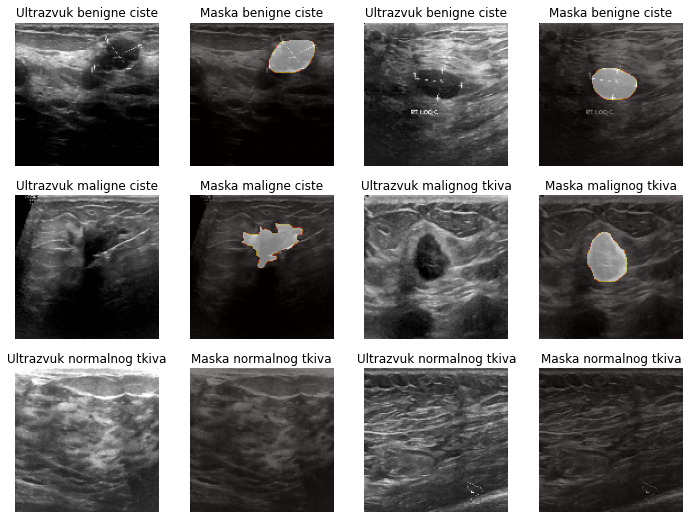

In [34]:
plt.figure(figsize=(12,9))
plt.subplot(3,4,1), plt.imshow(data_benign['img'][0]), plt.title('Ultrazvuk benigne ciste'), plt.axis('off')
plt.subplot(3,4,2), plt.imshow(data_benign['img'][0]), plt.imshow(data_benign['mask'][0], cmap='hot', alpha=0.5), plt.title('Maska benigne ciste'), plt.axis('off')
plt.subplot(3,4,3), plt.imshow(data_benign['img'][100]), plt.title('Ultrazvuk benigne ciste'), plt.axis('off')
plt.subplot(3,4,4), plt.imshow(data_benign['img'][100]), plt.imshow(data_benign['mask'][100], cmap='hot', alpha=0.5), plt.title('Maska benigne ciste'), plt.axis('off')
plt.subplot(3,4,5), plt.imshow(data_malignant['img'][0]), plt.title('Ultrazvuk maligne ciste'), plt.axis('off')
plt.subplot(3,4,6), plt.imshow(data_malignant['img'][0]), plt.imshow(data_malignant['mask'][0], cmap='hot', alpha=0.5), plt.title('Maska maligne ciste'), plt.axis('off')
plt.subplot(3,4,7), plt.imshow(data_malignant['img'][50]), plt.title('Ultrazvuk malignog tkiva'), plt.axis('off')
plt.subplot(3,4,8), plt.imshow(data_malignant['img'][50]), plt.imshow(data_malignant['mask'][50], cmap='hot', alpha=0.5), plt.title('Maska malignog tkiva'), plt.axis('off')
plt.subplot(3,4,9), plt.imshow(data_normal['img'][0]), plt.title('Ultrazvuk normalnog tkiva'), plt.axis('off')
plt.subplot(3,4,10), plt.imshow(data_normal['img'][0]), plt.imshow(data_normal['mask'][0], cmap='hot', alpha=0.5), plt.title('Maska normalnog tkiva'), plt.axis('off')
plt.subplot(3,4,11), plt.imshow(data_normal['img'][50]), plt.title('Ultrazvuk normalnog tkiva'), plt.axis('off')
plt.subplot(3,4,12), plt.imshow(data_normal['img'][50]), plt.imshow(data_normal['mask'][50], cmap='hot', alpha=0.5), plt.title('Maska normalnog tkiva'), plt.axis('off')
plt.show()

Formiranje trening i test seta, podela i mešanje podataka

In [35]:
print(np.array(data_benign['img']).shape)
print(np.array(data_benign['mask']).shape)
print(np.array(data_malignant['img']).shape)
print(np.array(data_malignant['mask']).shape)
print(np.array(data_normal['img']).shape)
print(np.array(data_normal['mask']).shape)

(421, 128, 128, 3)
(421, 128, 128)
(209, 128, 128, 3)
(209, 128, 128)
(133, 128, 128, 3)
(133, 128, 128)


Augmentovanje podataka iz normalnog i magignog dela dataseta

In [36]:
def augment_rotation(data_provided, total_samples):
    data = data_provided.copy()
    initial_samples, new_samp = len(data['img']), len(data['img'])
    for i in range(initial_samples):
        img = data['img'][i]
        mask = data['mask'][i]
        if new_samp >= total_samples:
            break
        for rot in [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]:
            img_rot = cv2.rotate(img, rot)
            mask_rot = cv2.rotate(mask, rot)
            data['img'].append(img_rot)
            data['mask'].append(mask_rot)
            new_samp += 1

    return data

In [37]:
data_malignant = augment_rotation(data_malignant, 420)
print(np.array(data_malignant['img']).shape)
print(np.array(data_malignant['mask']).shape)

data_normal = augment_rotation(data_normal, 400)
print(np.array(data_normal['img']).shape)
print(np.array(data_normal['mask']).shape)

(422, 128, 128, 3)
(422, 128, 128)
(400, 128, 128, 3)
(400, 128, 128)


In [38]:
data = {'img' : [], 'mask' : []}
data['img'].extend(data_benign['img'])
data['mask'].extend(data_benign['mask'])
data['img'].extend(data_malignant['img'])
data['mask'].extend(data_malignant['mask'])
data['img'].extend(data_normal['img'])
data['mask'].extend(data_normal['mask'])

### Model

In [2]:
def Conv2DBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
                            
    return x

In [3]:
def EncoderMiniBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = Conv2DBlock(inputTensor, numFilters, kernelSize, do_batch_norm)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    return x, p

In [4]:
def DecoderMiniBlock(inputTensor, skipTensor, numFilters, kernelSize = 3, do_batch_norm = True, dropout = 0.0):
    x = tf.keras.layers.Conv2DTranspose(numFilters, (3, 3), strides = 2, padding = 'same')(inputTensor)
    x = tf.keras.layers.concatenate([x, skipTensor])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = Conv2DBlock(x, numFilters, kernelSize, do_batch_norm)
    
    return x

In [5]:
def UNetModel(inputImage, numFilters = 16, droupouts = 0.1, do_batch_norm = True):

    c1, p1 = EncoderMiniBlock(inputImage, numFilters, kernelSize = 3, do_batch_norm = do_batch_norm)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2, p2 = EncoderMiniBlock(p1, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3, p3 = EncoderMiniBlock(p2, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4, p4 = EncoderMiniBlock(p3, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2DBlock(p4, numFilters * 16, kernelSize = 3, do_batch_norm = do_batch_norm)

    c6 = DecoderMiniBlock(c5, c4, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c7 = DecoderMiniBlock(c6, c3, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c8 = DecoderMiniBlock(c7, c2, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c9 = DecoderMiniBlock(c8, c1, numFilters * 1, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

Treniranje

In [43]:
modelUNet = UNetModel(tf.keras.layers.Input((128, 128, 3)))
modelUNet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]

X_train, X_val, Y_train, Y_val = train_test_split(np.array(data['img']), np.array(data['mask']), test_size=0.1, random_state=42, shuffle=True)
results = modelUNet.fit(X_train, Y_train, validation_split=0.1, epochs=50)

Epoch 1/50
32/32 [==============================] - 70s 2s/step - loss: 0.3806 - accuracy: 0.8995 - val_loss: 11.2275 - val_accuracy: 0.1280
Epoch 2/50
32/32 [==============================] - 61s 2s/step - loss: 0.2397 - accuracy: 0.9410 - val_loss: 11.1087 - val_accuracy: 0.1028
Epoch 3/50
32/32 [==============================] - 61s 2s/step - loss: 0.1992 - accuracy: 0.9456 - val_loss: 8.8580 - val_accuracy: 0.1181
Epoch 4/50
32/32 [==============================] - 61s 2s/step - loss: 0.1712 - accuracy: 0.9514 - val_loss: 1.6630 - val_accuracy: 0.5450
Epoch 5/50
32/32 [==============================] - 84s 3s/step - loss: 0.1611 - accuracy: 0.9511 - val_loss: 4.4170 - val_accuracy: 0.2772
Epoch 6/50
32/32 [==============================] - 133s 4s/step - loss: 0.1429 - accuracy: 0.9558 - val_loss: 0.8141 - val_accuracy: 0.7386
Epoch 7/50
32/32 [==============================] - 132s 4s/step - loss: 0.1281 - accuracy: 0.9599 - val_loss: 0.4608 - val_accuracy: 0.8406
Epoch 8/50
32/32

In [61]:
Y_pred = modelUNet.predict(X_val)
Y_pred = (Y_pred > 0.5).astype(int)
Y_val = Y_val.astype(int)

Čuvanje modela i rezultata

In [ ]:
modelUNet.save('modelUNet_augm.h5')
results.history['loss'] = np.array(results.history['loss'])
results.history['val_loss'] = np.array(results.history['val_loss'])
results.history['accuracy'] = np.array(results.history['accuracy'])
results.history['val_accuracy'] = np.array(results.history['val_accuracy'])
np.save('results_augm.npy', results.history)

In [62]:
test_metrics = {}
test_metrics['accuracy'] = accuracy_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['precision'] = precision_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['recall'] = recall_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['f1'] = f1_score(Y_val.flatten(), Y_pred.flatten())
np.save('test_metrics_augm.npy', test_metrics)
test_metrics

{'accuracy': 0.96113232421875,
 'precision': 0.7421636347056946,
 'recall': 0.7912299569214317,
 'f1': 0.7659117710198884}

Prikaz rezultata

In [47]:
results = np.load('results_augm.npy', allow_pickle=True).item()

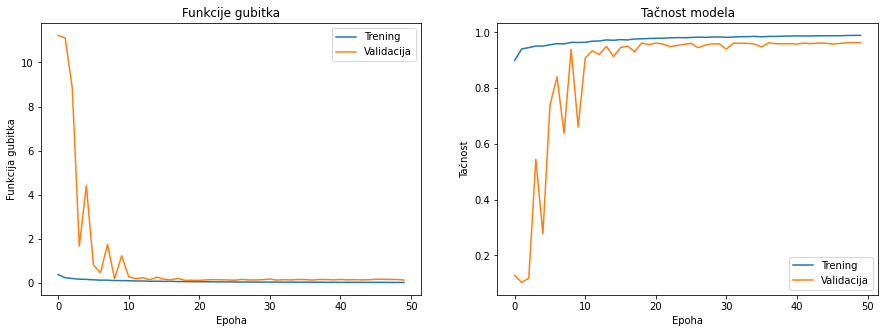

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2, 1), plt.plot(results['loss']), plt.plot(results['val_loss'])
plt.title('Funkcije gubitka'), plt.ylabel('Funkcija gubitka'), plt.xlabel('Epoha')
plt.legend(['Trening', 'Validacija'], loc='upper right')
plt.subplot(1,2, 2)
plt.plot(results['accuracy']), plt.plot(results['val_accuracy'])
plt.title('Tačnost modela'), plt.ylabel('Tačnost'), plt.xlabel('Epoha')
plt.legend(['Trening', 'Validacija'], loc='lower right')
plt.show()

Čuvanje predikcija i tačnih labela

In [49]:
database_new = {'img' : [],
              'mask' : [],
              'pred' : []
             }
             
for i in range(len(X_val)):
    database_new['img'].append(X_val[i])
    database_new['mask'].append(Y_val[i])
    database_new['pred'].append(Y_pred[i])

np.save('test_results_augm.npy', database_new)

Prikaz dobrih i losih rezultata

In [327]:
database_new = np.load('test_results_augm.npy', allow_pickle=True).item()
Y_val = np.array(database_new['mask'])
Y_pred = np.array(database_new['pred'])
X_val = np.array(database_new['img'])

Primeri dobro registrovanih lezija

In [328]:
# za neaugmentovane slike
#i1, i2, i3, i4, i5, i6 = 15, 3, 19, 26, 2, 6
# za augmentovane slike
i1, i2, i3, i4, i5, i6 = 12, 17, 2, 49, 5, 1

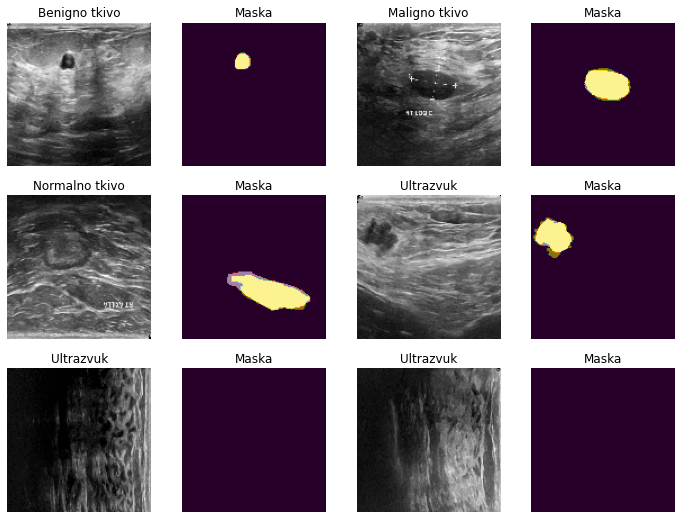

In [329]:
plt.figure(figsize=(12,9))
plt.subplot(3,4,1), plt.imshow(X_val[i1]), plt.title('Benigno tkivo'), plt.axis('off')
plt.subplot(3,4,2), plt.imshow(Y_val[i1].reshape(128, 128)), plt.imshow(Y_pred[i1].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,3), plt.imshow(X_val[i2]), plt.title('Maligno tkivo'), plt.axis('off')
plt.subplot(3,4,4), plt.imshow(Y_val[i2].reshape(128, 128)), plt.imshow(Y_pred[i2].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,5), plt.imshow(X_val[i3]), plt.title('Normalno tkivo'), plt.axis('off')
plt.subplot(3,4,6), plt.imshow(Y_val[i3].reshape(128, 128)), plt.imshow(Y_pred[i3].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,7), plt.imshow(X_val[i4]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,8), plt.imshow(Y_val[i4].reshape(128, 128)), plt.imshow(Y_pred[i4].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,9), plt.imshow(X_val[i5]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,10), plt.imshow(Y_val[i5].reshape(128, 128)), plt.imshow(Y_pred[i5].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,11), plt.imshow(X_val[i6]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,12), plt.imshow(Y_val[i6].reshape(128, 128)), plt.imshow(Y_pred[i6].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.show()

Primer loše registrovanih lezija

In [332]:
# za neaugmentovane slike
#j1, j2, j3, j4, j5, j6 = 9, 11, 5, 17, 60, 61
# za augmentovane slike
j1, j2, j3, j4, j5, j6 = 36, 50, 54, 3, 32, 31

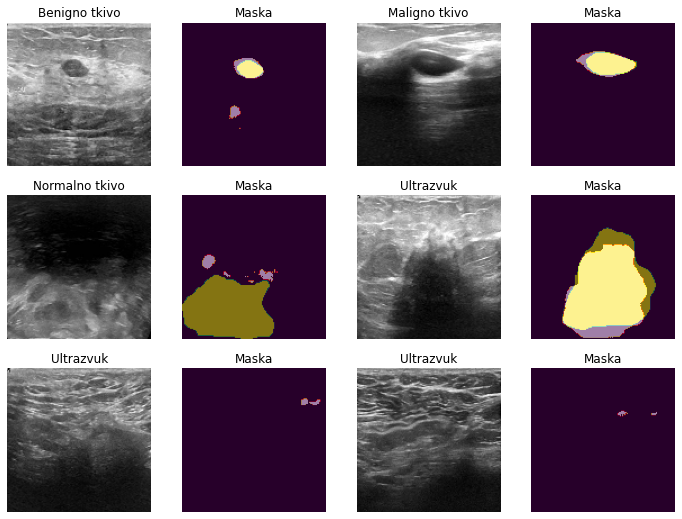

In [333]:
plt.figure(figsize=(12,9))
plt.subplot(3,4,1), plt.imshow(X_val[j1]), plt.title('Benigno tkivo'), plt.axis('off')
plt.subplot(3,4,2), plt.imshow(Y_val[j1].reshape(128, 128)), plt.imshow(Y_pred[j1].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,3), plt.imshow(X_val[j2]), plt.title('Maligno tkivo'), plt.axis('off')
plt.subplot(3,4,4), plt.imshow(Y_val[j2].reshape(128, 128)), plt.imshow(Y_pred[j2].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,5), plt.imshow(X_val[j3]), plt.title('Normalno tkivo'), plt.axis('off')
plt.subplot(3,4,6), plt.imshow(Y_val[j3].reshape(128, 128)), plt.imshow(Y_pred[j3].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,7), plt.imshow(X_val[j4]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,8), plt.imshow(Y_val[j4].reshape(128, 128)), plt.imshow(Y_pred[j4].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,9), plt.imshow(X_val[j5]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,10), plt.imshow(Y_val[j5].reshape(128, 128)), plt.imshow(Y_pred[j5].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.subplot(3,4,11), plt.imshow(X_val[j6]), plt.title('Ultrazvuk'), plt.axis('off')
plt.subplot(3,4,12), plt.imshow(Y_val[j6].reshape(128, 128)), plt.imshow(Y_pred[j6].reshape(128, 128), cmap='hot', alpha=0.5), plt.title('Maska'), plt.axis('off')
plt.show()

Vizuelizacija modela

In [13]:
#load 'modelUNet.h5'
model1 = tf.keras.models.load_model('modelUNet_augm.h5')

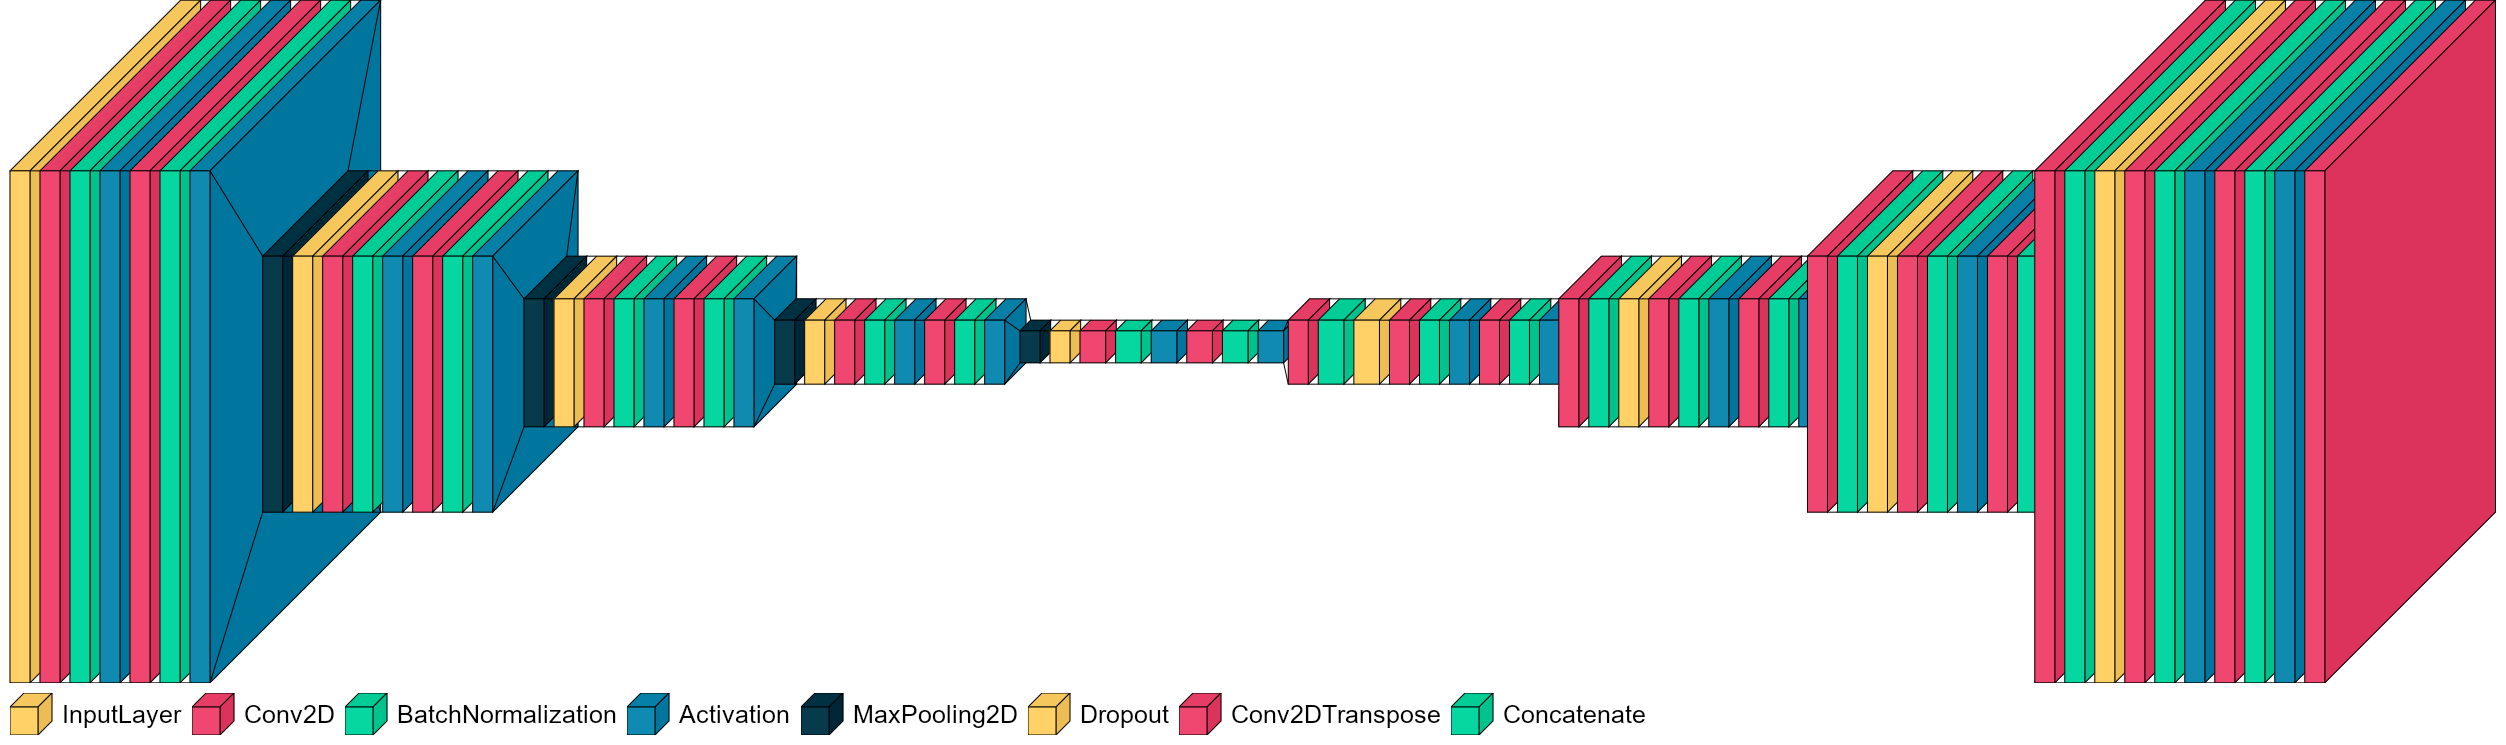

In [14]:
visualkeras.layered_view(model1, legend=True) 
font = ImageFont.truetype("arial.ttf", 25)
visualkeras.layered_view(model1, legend=True, draw_volume=True, font = font)

### Matrice konfuzije

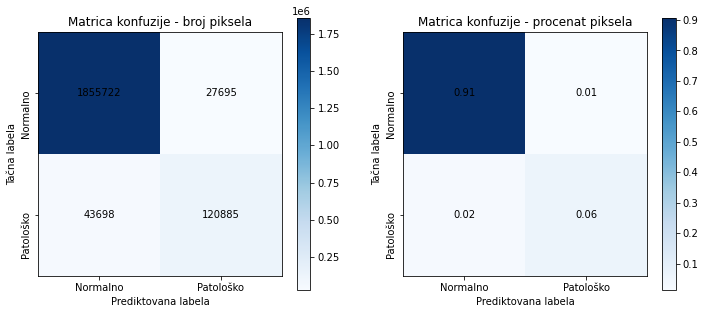

In [31]:
data = np.load('results/test_results_augm.npy', allow_pickle=True).item()

# plot confusion matrix for pixels, sum over all images
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    cm1 = cm / cm.sum().sum()

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.xticks([0, 1], ['Normalno', 'Patološko'])
    plt.yticks([0, 1], ['Normalno', 'Patološko'], rotation='vertical')
    plt.grid(False)
    #plot nums in confusion matrix
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(cm[x][y], 2)), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.title('Matrica konfuzije - broj piksela')
    plt.colorbar()
    plt.ylabel('Tačna labela')
    plt.xlabel('Prediktovana labela')

    plt.subplot(1,2,2)
    plt.imshow(cm1, cmap='Blues', interpolation='nearest')
    plt.xticks([0, 1], ['Normalno', 'Patološko'])
    plt.yticks([0, 1], ['Normalno', 'Patološko'], rotation='vertical')
    plt.grid(False)
    #plot nums in confusion matrix
    width, height = cm1.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(cm1[x][y], 2)), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.title('Matrica konfuzije - procenat piksela')
    plt.colorbar()
    plt.ylabel('Tačna labela')
    plt.xlabel('Prediktovana labela')
    plt.show()

true_d = np.array(data['mask'])
pred_d = np.array(data['pred'])

plot_confusion_matrix(true_d, pred_d)